Computational modeling in python, SoSe2022 

# Interpolation of functions

Imagine you know only values of a function at specific points, but in fact you need values at arbitrary points in between. This is achieved through interpolation - the function is modeled by a plausible functional form. 

The interpolation process has two stages:
1. Fit the interpolating function to reproduce existing values 
2. Evaluate the interpolating function at the target point.

There are few things one should keep in mind when attempting such a procedure:
- There is no information about the true value of the function at some point in between the known points.
- In fact, assumptions about the form of the function have to be made and those could be wrong.  



Let us try a few methods on a number of data sets

## 1. Read in the data

The data is stored in a common text format for matrices: two integers and a float (or other) value per line. The integers encode the indices and the float encodes the value of the matrix at the indices.

<pre>"i j value" --> matrix[i,j] = value</pre>


In [1]:
from numpy import *
import matplotlib.pyplot as plt

In [17]:
nofuncs=4    # number of functions
nopoints=4   # number points in each function

myval=zeros((nofuncs,nopoints)) # total data

with open('data_problem5.dat') as f:
    for line in f:
        # split a string in words
        myline=line.split()
        
        i=int(myline[0])-1  # the index of the text file is 1-based
        j=int(myline[1])-1
        myval[i,j]=float(myline[2])
        
        
print("myval: \n", myval)

# the x-values for the points are just the indices of the points:
x = array(range(nopoints), dtype=double)
print("x: \n", x)

myval: 
 [[ 0.15202188  0.17954333  0.21984052  0.24929105]
 [-0.29626381 -0.34633402 -0.11739668 -0.0858507 ]
 [-0.05723576  0.00247443  0.04641788  0.04980591]
 [ 0.17006386  0.18133864  0.11163959  0.18692696]]
x: 
 [0. 1. 2. 3.]


We will interpret each row of the matrix as a function known at the points. Let's plot the functions. Note that we do not input x-values to the plot command. In this case the indices of the array will be used as x-values. So with 4 points the function is interpreted as a function in the interval $[0,3]$.


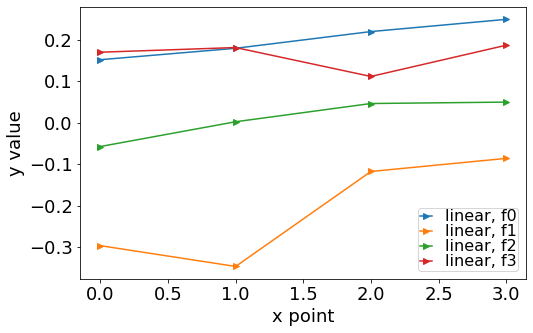

In [14]:
mf=16 #fontsize

fig, ax = plt.subplots(figsize=(8,5))

# loop over the rows and plot them
for k in range(nofuncs):
    ax.plot(x, myval[k],marker='>',label='linear, f{}'.format(k))

ax.set_xlabel('x point',fontsize=18)
ax.set_ylabel('y value',fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

legend = ax.legend(loc='lower right', shadow=False,fontsize=mf,borderpad = 0.1, labelspacing = 0, handlelength = 0.8)

#plt.savefig('problem3_linear.pdf',dpi=300,bbox_inches='tight')

plt.show()

## 2. Linear interpolation

In linear interpolation, two neighboring points $x_j$ and $x_{j+1}$ are connected by a straight line, and the linear function between these two points provides the mapping for arbitrary points in the interval $[x_i,x_{i+1})$ and  $[x_{N-1},x_{N}]$ for the last segment.

\begin{align}
  f_i(x)=a_i x + b_i
\end{align}

(We use for the index $i$ of the function the same index as for the left point.) For $N$ points that are being interpolated, the overall function is $N-1$ piecewise linear, as shown in the plot above. Each of the given points is connected to the next point by a straight line. Linear interpolation is a special case of polynomial interpolation.

Since we have to interpolate the function in $N-1$ intervals and for each interval we need to determine 2 coefficients, $a_i$ and $b_i$, the overall number of parameters that need to be calculated ins $2N-2$. 

The coefficients are obtained by requiring $f_i(x_i) = y_i$ and $f_i(x_{i+1}) = y_{i+1}$  as:

\begin{align}
a_i & = \frac{\Delta y}{\Delta x} = \frac{y_{i+1}-y_{i}}{x_{i+1}-x_{i}}\\
b_i & = y_i - \frac{y_{i+1}-y_{i}}{x_{i+1}-x_{i}} x_i 
\end{align}
Putting this back into the original formula we get
\begin{align}
f_i(x) & = \frac{y_{i+1}-y_i}{x_{i+1}-x_i}(x-x_i) + y_i \\[.4cm]
       & = \frac{x-x_i}{x_{i+1}-x_i}y_{i+1} + \frac{x_{i+1}-x}{x_{i+1}-x_i}y_i\\[.4cm]
       & = \frac{x-x_i}{\Delta x_i}y_{i+1} + \frac{x_{i+1}-x}{\Delta x_i}y_i
       \label{eq:linear} \tag{1}
\end{align}



We will now perform a linear interpolation for the four functions above, onto a finer grid of 12 evenly spaced points, from the given four data points. The new points are computed according to

*Note that there are many different ways to write and arrange these routines, we will start with a more simple and sequential syntax.*

In [19]:
nint = 13  # number of new points for each function (the "fine grid")

xval = zeros((nint))     # x on the fine grid for all functions
linval = zeros((nofuncs, nint))   # the interpolated functions

# spacing between the new x values
# we have N-1 intervals that are equally divided into nint pieces

dx = (x[-1]-x[0])/(nint-1) 

print('The spacing between the interpolated points is',dx)

# determine the x values for all four functions
for j in range(nint):
    xval[j] = x[0] + j*dx

print('xval: ', xval)

# the interval in which the new points are
xloc =  zeros(nint, dtype=int)

# loop through all original and new points and determine 
# in which interval the points on the fine grid are
for j in range(nint):
    for k in range(nopoints):
        if k < nopoints -1:
            if xval[j] >= x[k] and xval[j] < x[k+1]:
                xloc[j] = k
                # we found the location and there is no
                # need to continue looping over the remining k
                # so we end the inner for loop for k here
                break #once found, break most inner loop, so in this case the for loop with variable k
        else:
            xloc[j] = k-1
            
print('xloc: ', xloc)        

# now compute the y values on the interpolated points
for k in range(nofuncs):
    for j in range(nint):
        
        # 'i' is the interval, j is the fine grid
        xi = xloc[j]
        xiplus1 = xloc[j] + 1
        
        yi = myval[k,xi]
        yiplus1 = myval[k, xiplus1]
        
        #now we can compute the new y value for the given x
        # linval[k, j] = yj + (xval[j] - xj) * (yjplusone - yj)/(xjplusone - xj) #OG function, f = ax + b
        linval[k, j] = (xval[j] - xi)/(xiplus1 - xi)*yiplus1 + (xiplus1-xval[j])/(xiplus1 - xi)*yi

The spacing between the interpolated points is 0.25
xval:  [0.   0.25 0.5  0.75 1.   1.25 1.5  1.75 2.   2.25 2.5  2.75 3.  ]
xloc:  [0 0 0 0 1 1 1 1 2 2 2 2 2]


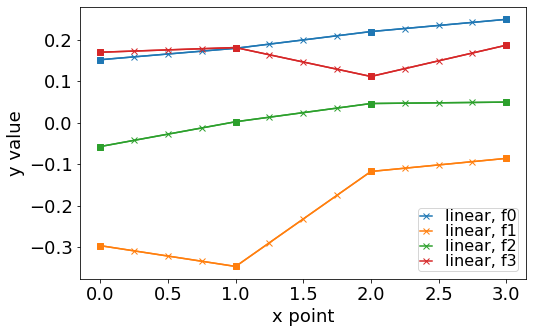

In [20]:
# matplotlib has a default coloring scheme 
# to give different functions plotted in the same 
# graph a different color. Here we just 
# extract the color sequence to make 
# sure the interpolated and original 
# functions are plotted with the same color
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']


fig, ax = plt.subplots(figsize=(8,5))

# loop through functions and plot
for n in range(nofuncs):
    ax.plot(xval,linval[n],marker='x',color=colors[n],label='linear, f{}'.format(n))
    ax.plot(myval[n],marker="s",color=colors[n])

# set some figure properties
ax.set_xlabel('x point',fontsize=18)
ax.set_ylabel('y value',fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
legend = ax.legend(loc='lower right', shadow=False,fontsize=mf,borderpad = 0.1, labelspacing = 0, handlelength = 0.8)

# plt.savefig('problem3_linear.pdf',dpi=300,bbox_inches='tight')
plt.show()

__This can all be done much easier using the numpy library:__

In [21]:
linvals2=zeros((nofuncs,nint)) #interp function


for i in range(nofuncs):
    linvals2[i] = interp(xval,x,myval[i])

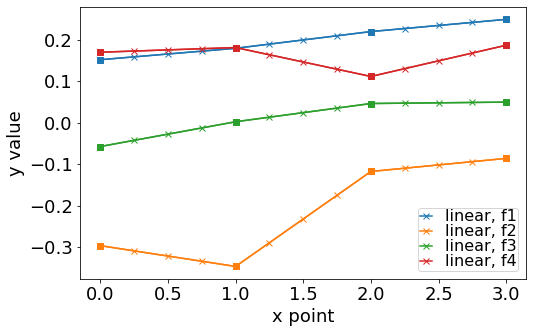

In [22]:
fig, ax = plt.subplots(figsize=(8,5))
for i in range(nofuncs):
    ax.plot(xval,linvals2[i],marker='x',color=colors[i],label='linear, f{}'.format(i+1))
    ax.plot(myval[i],marker='s',color=colors[i])

ax.set_xlabel('x point',fontsize=18)
ax.set_ylabel('y value',fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
legend = ax.legend(loc='lower right', shadow=False,fontsize=mf,borderpad = 0.1, labelspacing = 0, handlelength = 0.8)
#plt.savefig('problem3_linear.pdf',dpi=300,bbox_inches='tight')
plt.show()

__Note how easy this is using the library! Generally, we will employ available libraries from now on <span style="color:darkgreen"> where possible </span> and not implement the numerical methods from scratch!!__

A huge disadvantage of linear interpolation is that the derivatives are not continuous:

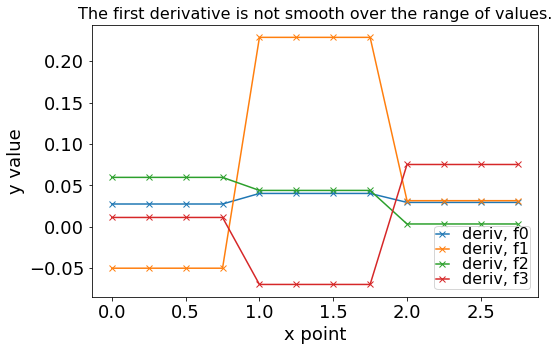

In [23]:
deriv=zeros((nofuncs,nint-1)) 

for k in range(nofuncs):
    for j in range(nint-1):
        
        # simple derivative: deltay/deltax
        deriv[k,j] = (linval[k,j+1]-linval[k,j])/(xval[j+1] - xval[j]) 



fig, ax = plt.subplots(figsize=(8,5))
for k in range(nofuncs):
    ax.plot(xval[0:(nint-1)], deriv[k] ,marker='x',label='deriv, f{}'.format(k))
    #ax.plot(myval[i],marker='<')

ax.set_xlabel('x point',fontsize=18)
ax.set_ylabel('y value',fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

plt.title('The first derivative is not smooth over the range of values.',fontsize=mf)
legend = ax.legend(loc='lower right', shadow=False,fontsize=mf,borderpad = 0.1, labelspacing = 0, handlelength = 0.8)
#plt.savefig('problem3_linear.pdf',dpi=300,bbox_inches='tight')
plt.show()

For continuous first and second derivatives, we need to resort to a different numerical approach.

## Cubic spline interpolation

With a cubic spline interpolation, smooth first derivatives and continuous second derivatives are obtained for each interpolated point.


Another advantage is that, contrary to standard polynomial interpolation where an $(N-1)$-degree polynomial is fitted to $N$ data points, overfitting is avoided. (Overfitting occurs for example in polynomial interpolation when simple data is represented with an excessively complicated form, and manifests itself in an oscillatory behavior of the fit.) 

Spline fitting is achieved by fitting in each interval $[x_i, x_{i+1}]$ to a polynomial form of 
\begin{align}
P_i(x)=a_i x^3 + b_i x^2 + c_i x + d_i
\end{align}

In this approach, each segment between two neighboring data points is represented by its own polynomial $P_i(x)$, resulting in a piecewise polynomial function $S(x)$ of $n-1$ polynomials ("spline"):
\begin{align}
S(x) =
\left\{
\begin{array}{cc}
P_0(x) & x_0 \le x \lt x_1 \\
P_1(x) & x_1 \le x \lt x_2\\
\vdots & \\
P_{N-2}(x)  & x_{n-2} \le x \le x_{N-1} \\
\end{array}
\right.
\end{align}

A natural cubic spline has zero value for $P''(x_0)$ and $P''(x_{N-1})$ and is the most typical case, but  other cases are possible. 

To obtain a continuous and smooth function $S(x)$ and derivatives, each consecutive polynomial $P_i(x)$ and $P_{i+1}(x)$ must have the same functional value and derivatives at the joining points $x_i$. 
The conditions that have to be met are 
\begin{align}
 P_i(x_i) & = y_i \label{eq:con1}\tag{i}\\
 P_i(x_{i+1}) & = y_{i+1} \label{eq:con2}\tag{ii}\\
 P_i''(x_i) & = \alpha_i \label{eq:con3}\tag{iii}\\
 P_i''(x_{i+1}) &= \alpha_{i+1} \label{eq:con4}\tag{iv}\\
\end{align}

One can start now with the second derivatives: They are piecewise linear functions we could fit as above and integrate from there on. However, we do not know the $\alpha_i$ values of the second derivatives on the joining points yet. Let us start with Eq. (1): The $\alpha_i$ now take the positions of the $y_i$ in the linear fit.

\begin{align}
P''_i(x) & = \frac{x-x_i}{\Delta x_i}\alpha_{i+1} + \frac{x_{i+1}-x}{\Delta x_i}\alpha_i
\end{align} 

and integrate twice:

\begin{align}
P'_i(x) & = \frac{1}{2}\frac{(x-x_i)^2}{\Delta x_i}\alpha_{i+1} + \frac{1}{2}\frac{(x_{i+1}-x)^2}{\Delta x_i}\alpha_i + r_i
\label{eq:first}\tag{2}
\end{align} 

\begin{align}
P_i(x) & = \frac{1}{6}\frac{(x-x_i)^3}{\Delta x_i}\alpha_{i+1} + \frac{1}{6}\frac{(x_{i+1}-x)^3}{\Delta x_i}\alpha_i + r_i (x-x_i) + s_i
\label{eq:zeroth}\tag{3}
\end{align} 

The two integration constants $r_i$ and $s_i$ in Eq. (3) can now be fixed with conditions (i) and (ii):


\begin{align}
r_i & = \frac{y_{i+1}-y_i}{\Delta x_i} - \frac{1}{6}(\Delta x_i)^2(\alpha_{i+1}-\alpha_i)\\
s_i & = y_i - \frac{(\Delta x_i)^2}{6}\alpha_i
\end{align} 

Once the two parameters are fixed, we can look at the first derivatives and use

\begin{align}
P'_{i-1}(x_{i}) =  P'_{i}(x_i)
\end{align} 

We get:


\begin{align}
\frac{1}{6}\Delta x_{i-1}\alpha_{i-1} + \frac{1}{3}( \Delta x_{i-1} +  \Delta x_{i})  \alpha_{i} +  \frac{1}{6}\Delta x_{i+1}\alpha_{i+1}  & =\frac{y_{i+1}-y_i}{\Delta x_i}  - \frac{y_{i}-y_{i-1}}{\Delta x_{i-1}} \\
\end{align}



This can be written in a matrix form ($\alpha_0 = \alpha_{N-1} = 0$ )

\begin{align}
\left[
\begin{array}{cccccc}
\frac{\Delta x_0 + \Delta x_1}{3} & \frac{\Delta x_1 }{6} & & & & \\
\frac{\Delta x_1}{6} & \frac{\Delta x_1 + \Delta x_2}{3} & \frac{\Delta x_2 }{6} & & & \\
& \ddots & \ddots & \ddots & & \\
& & \frac{\Delta x_{i-1} }{6} & \frac{\Delta x_{i-1} + \Delta x_i}{3} & \frac{\Delta x_i}{6} & \\
& & & \ddots & \ddots & \ddots \\
& & & & \frac{\Delta x_{N-3}}{6} & \frac{\Delta x_{N-3} + \Delta x_{N-2}}{3} \\
\end{array} 
\right]
\left[
\begin{array}{c}
\alpha_1 \\
\alpha_2 \\
\vdots \\
\alpha_i \\
\vdots \\
\alpha_{N-2} \\
\end{array}
\right]
=
\left[
\begin{array}{c}
\frac{y_{2}-y_1}{\Delta x_1}  - \frac{y_{1}-y_{0}}{\Delta x_{0}} \\
\frac{y_{3}-y_2}{\Delta x_2}  - \frac{y_{2}-y_{1}}{\Delta x_{1}}\\
\vdots \\
\frac{y_{i+1}-y_i}{\Delta x_i}  - \frac{y_{i}-y_{i-1}}{\Delta x_{i-1}} \\
\vdots \\
\frac{y_{N-1}-y_{N-2}}{\Delta x_{N-2}}  - \frac{y_{N-2}-y_{N-3}}{\Delta x_{N-3}}\\
\end{array}
\right]
\end{align}

This one can solve with a linear algebra solver and insert into $P_i(x)$

A cubic spline interpolation can easily be performed using scipy.

In [24]:
from scipy.interpolate import CubicSpline

xval2=linspace(0,nopoints-1,16)
csval=zeros((nofuncs),dtype=ndarray)

for i in range(nofuncs):
    
    # CubicSpline really returns a scipy.interpolate.PPoly object. It contains
    # a Piecewise polynomial. One can call it like a function, for instance
    # csval[i](2.1) will return the fit value of function i at point x=2.1
    # it can also return the derivative when you give an optional second argument:
    # csval[i](2.1, n): n'th derivative at point x=2.1
    
    # the argument bc_type="natural" sets the boundary conditions
    # such that the second derivatove on the end points is zero. 
    # CubicSpline offers several types of boundary conditions,
    # see help of CubicSpline. 
    csval[i] = CubicSpline(x, myval[i], bc_type="natural")

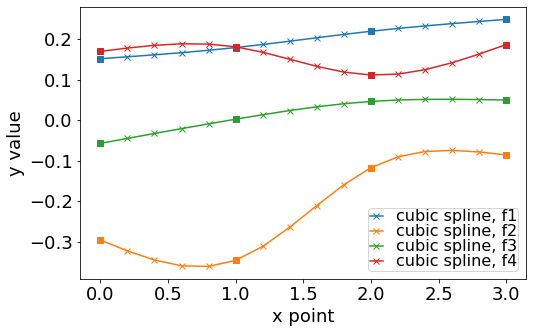

In [25]:
fig, ax = plt.subplots(figsize=(8,5))

for i in range(nofuncs):
    
    # PPoly can be used like a function
    ax.plot(xval2,csval[i](xval2),marker='x',color=colors[i],label='cubic spline, f{}'.format(i+1))
    ax.plot(myval[i],marker='s',color=colors[i],linestyle='')
    
    #csval[i](xval2) - round braket notation for function call

ax.set_xlabel('x point',fontsize=18)
ax.set_ylabel('y value',fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
legend = ax.legend(loc='lower right', shadow=False,fontsize=mf,borderpad = 0.1, labelspacing = 0, handlelength = 0.8)
#plt.savefig('problem3_cubicspline.pdf',dpi=300,bbox_inches='tight')
plt.show()

We can see that the first and second derivatives are continuous.

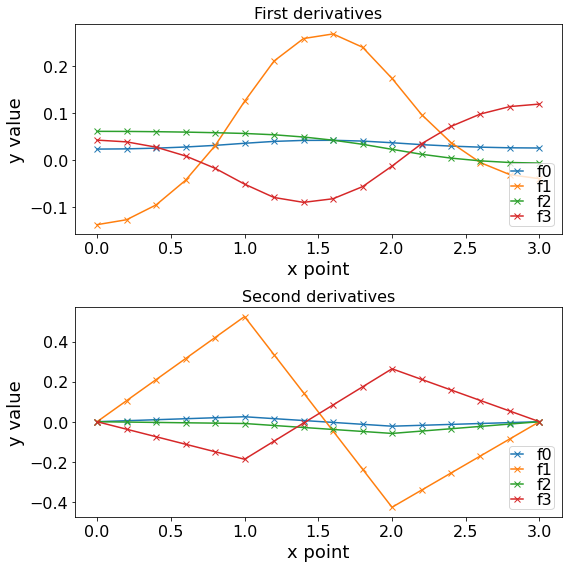

In [13]:
noderivs=2

tt = ['First','Second']

# create a plot with a number of panels:

fig, ax = plt.subplots(noderivs,figsize=(8,4*noderivs))
# number of panels -----^

# we now have a figure object and a list of axis

for j in range(noderivs):
    for i in range(nofuncs):
        
        # second argument of PPoly is the derivative
        ax[j].plot(xval2,csval[i](xval2,j+1),marker='x',color=colors[i],label='f{}'.format(i))

    ax[j].set_title('{} derivatives'.format(tt[j]),fontsize=mf)
    ax[j].set_xlabel('x point',fontsize=18)
    ax[j].set_ylabel('y value',fontsize=18)
    ax[j].tick_params(labelsize=mf)
    legend = ax[j].legend(loc='lower right', shadow=False,fontsize=mf,borderpad = 0.1, labelspacing = 0, handlelength = 0.8)
plt.tight_layout()
plt.show()

# Problem 3: Best function

The file `data_problem3_task1.dat` contains the time-dependent dipole moment of HeH$^+$ during irradiation with a laser pulse of 53 fs length. The left column is the time value and the right column contains the dipole moment value in atomic units.

Use the data in `data_problem3_task1.dat` to perform a linear and a cubic spline interpolation. Plot your results.

In a second experiment, the time-dependent dipole moment of HeH$^+$ was recorded on a much finer time grid. The real data is contained in `data_problem3_task2.dat`. Compare your fit to the real data - what do you notice?

__Optional additional task (no requirement)__

Repeat the above steps for the data in file `data_problem3_task3.dat`; this file contains the photodissociation probability of NaI over time. Compare to the real data in `data_problem3_task4.dat`.

Upload your notebook to moodle.